# Aggregate diagnostics from advanced diagnostics JSON

Load `outputs/figures/diagnostics/diagnostics_summary.json`, compute summary statistics across example windows (change-points, seasonal std, lagged-correlation differences), save `diagnostics_aggregate.json`, and show quick plots.


In [1]:
import os
os.chdir(r"C:\Abdullah_Stock-Prices_Training_2")
import json
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "outputs/figures/diagnostics"
summary_path = os.path.join(OUT_DIR, "diagnostics_summary.json")

if not os.path.exists(summary_path):
    raise SystemExit("Run advanced_diagnostics_tf.py first (no diagnostics_summary.json found).")

with open(summary_path, "r", encoding="utf-8") as f:
    summary = json.load(f)

wins = summary.get("windows", [])
N = len(wins)
print(f"Loaded diagnostics summary: {summary_path} -> {N} windows")


Loaded diagnostics summary: outputs/figures/diagnostics\diagnostics_summary.json -> 3 windows


## Compute aggregates
- avg change-points per window (real/synth)
- fraction of windows with any change-point
- average seasonal std from STL (real/synth)
- average peak absolute lagged-correlation difference per pair


In [2]:
# initialize
agg = {
    "N_windows": N,
    "avg_cps_per_window_real": 0.0,
    "avg_cps_per_window_synth": 0.0,
    "windows_with_cps_real_frac": 0.0,
    "windows_with_cps_synth_frac": 0.0,
    "avg_seasonal_std_real": 0.0,
    "avg_seasonal_std_synth": 0.0,
    "avg_peak_lag_abs_corr_diff": 0.0
}

cps_r = []
cps_s = []
season_r = []
season_s = []
peak_corrs = []

for w in wins:
    cpr_total = 0
    cps_total = 0
    # features may be a dict mapping feature name -> info
    features = w.get("features", {})
    for fname, info in features.items():
        # handle missing keys gracefully
        cr = info.get("cps_real", [])
        cs = info.get("cps_synth", [])
        # some code saved lists of change-point indices including last index as length marker:
        # count actual breakpoints as len(list)-1 if list-like, else 0
        try:
            cpr_total += max(0, len(cr) - 1) if isinstance(cr, (list, tuple)) else 0
        except Exception:
            pass
        try:
            cps_total += max(0, len(cs) - 1) if isinstance(cs, (list, tuple)) else 0
        except Exception:
            pass

        # season std
        stl_r = info.get("stl_real", {})
        stl_s = info.get("stl_synth", {})
        if "seasonal_std" in stl_r:
            try:
                season_r.append(float(stl_r["seasonal_std"]))
            except Exception:
                pass
        if "seasonal_std" in stl_s:
            try:
                season_s.append(float(stl_s["seasonal_std"]))
            except Exception:
                pass

    cps_r.append(cpr_total)
    cps_s.append(cps_total)

    # lagged correlation pairs
    lagged = w.get("lagged_corr", {})
    for pair, laginfo in lagged.items():
        cr = np.array(laginfo.get("corr_real", []), dtype=float) if laginfo.get("corr_real") is not None else np.array([])
        cs = np.array(laginfo.get("corr_synth", []), dtype=float) if laginfo.get("corr_synth") is not None else np.array([])
        if cr.size and cs.size and cr.shape == cs.shape:
            # peak absolute difference
            peak_corrs.append(float(np.max(np.abs(cr - cs))))
        elif cr.size and cs.size:
            # shapes mismatch: try to align by min length
            m = min(cr.size, cs.size)
            peak_corrs.append(float(np.max(np.abs(cr[:m] - cs[:m]))))
        else:
            # skip if no data
            pass

# finalize aggregates with safe-nan handling
def safe_mean(arr):
    try:
        return float(np.mean(arr)) if len(arr) > 0 else 0.0
    except Exception:
        return 0.0

agg["avg_cps_per_window_real"] = safe_mean(cps_r)
agg["avg_cps_per_window_synth"] = safe_mean(cps_s)
agg["windows_with_cps_real_frac"] = safe_mean([1.0 if x > 0 else 0.0 for x in cps_r])
agg["windows_with_cps_synth_frac"] = safe_mean([1.0 if x > 0 else 0.0 for x in cps_s])
agg["avg_seasonal_std_real"] = safe_mean(season_r)
agg["avg_seasonal_std_synth"] = safe_mean(season_s)
agg["avg_peak_lag_abs_corr_diff"] = safe_mean(peak_corrs)

outp = os.path.join(OUT_DIR, "diagnostics_aggregate.json")
with open(outp, "w", encoding="utf-8") as f:
    json.dump(agg, f, indent=2)

print("Saved aggregate diagnostics to", outp)
print(json.dumps(agg, indent=2))


Saved aggregate diagnostics to outputs/figures/diagnostics\diagnostics_aggregate.json
{
  "N_windows": 3,
  "avg_cps_per_window_real": 8.0,
  "avg_cps_per_window_synth": 0.6666666666666666,
  "windows_with_cps_real_frac": 1.0,
  "windows_with_cps_synth_frac": 0.3333333333333333,
  "avg_seasonal_std_real": 1.0657869527124462,
  "avg_seasonal_std_synth": 55.58349145506434,
  "avg_peak_lag_abs_corr_diff": 1.2575985549540025
}


## Quick plots to inspect aggregates
- Histogram of change-point counts per window (real vs synth)
- Seasonal std comparison (boxplot)
- Peak lagged-corr differences (histogram)


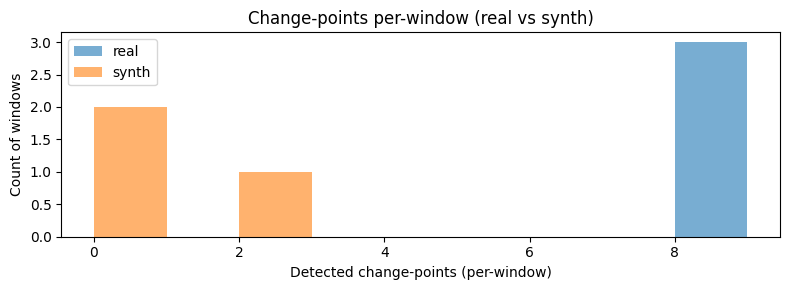

In [3]:
# %%
# Cell 1 - Histogram: change-point counts per window (real vs synth)
import matplotlib.pyplot as plt
import numpy as np

# defensive defaults if lists missing
cps_r = globals().get("cps_r", [])
cps_s = globals().get("cps_s", [])

plt.figure(figsize=(8,3))
bins = range(0, max(cps_r + cps_s + [0]) + 2)  # compute combined max safely
plt.hist(cps_r, bins=bins, alpha=0.6, label="real")
plt.hist(cps_s, bins=bins, alpha=0.6, label="synth")
plt.xlabel("Detected change-points (per-window)")
plt.ylabel("Count of windows")
plt.title("Change-points per-window (real vs synth)")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Abdul Ahad\AppData\Local\Temp\ipykernel_24928\1766891165.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["seasonal_std_real", "seasonal_std_synth"])


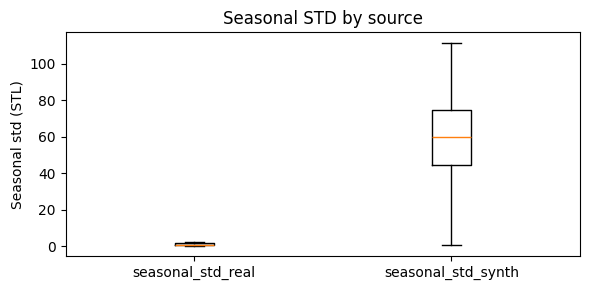

In [4]:
# %%
# Cell 2 - Seasonal standard deviation boxplot (from STL seasonal component)
import matplotlib.pyplot as plt
import numpy as np

season_r = globals().get("season_r", [])
season_s = globals().get("season_s", [])

# ensure non-empty lists for plotting
data = [season_r if len(season_r)>0 else [0.0],
        season_s if len(season_s)>0 else [0.0]]

plt.figure(figsize=(6,3))
plt.boxplot(data, labels=["seasonal_std_real", "seasonal_std_synth"])
plt.ylabel("Seasonal std (STL)")
plt.title("Seasonal STD by source")
plt.tight_layout()
plt.show()


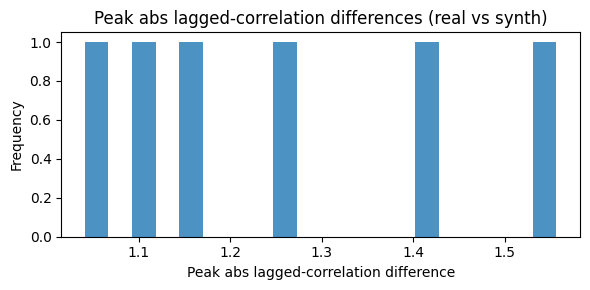

In [5]:
# %%
# Cell 3 - Histogram: peak absolute lagged-correlation differences
import matplotlib.pyplot as plt

peak_corrs = globals().get("peak_corrs", None)

if peak_corrs and len(peak_corrs) > 0:
    plt.figure(figsize=(6,3))
    plt.hist(peak_corrs, bins=20, alpha=0.8)
    plt.xlabel("Peak abs lagged-correlation difference")
    plt.ylabel("Frequency")
    plt.title("Peak abs lagged-correlation differences (real vs synth)")
    plt.tight_layout()
    plt.show()
else:
    print("No lagged-correlation info available to plot (peak_corrs is empty or not defined).")


## Notes & tuning tips
- The code treats ruptures' `predict()` output as a list of break indices (includes final index). We subtract 1 to count breakpoints; if your stored format differs, you may need to adjust.
- If `seasonal_std` is missing for many features, check that STL ran successfully in `advanced_diagnostics_tf.py` (it saves per-feature STL metadata).
- Peak lagged-correlation differences are sensitive to the `MAX_LAG` used when computing lagged_corr. If you want an L1-sum or RMS difference instead, we can add that.
- Want these aggregates combined into a CSV / table with per-feature rows instead of window-level aggregates? I can paste that cell next.
